# fig6_upper
SALLJ composites of 250-hPa geopotential heights (contour lines), isotachs (contour shading), and wind vectors


## Imports

In [1]:
# Standard Python modules
import os, sys
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

# Extra 
from scipy.ndimage import gaussian_filter    # smoothing contour lines
import metpy.calc as mpcalc
from metpy.units import units
from IPython.display import Image, display

# import personal modules

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [3]:
# Set a default font for all matplotlib text 
rcParams['font.family'] = 'sans-serif'   # font family = 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # default sans-serif font = 'Arial'


## Data

### ERA5 renalysis

In [5]:
## Set variable names (for saving data/figs)
var_names = 'HUV250QUV850'
eofmode = 't' # s or t
dispmat = 'cor' # dispersion matrix type correlation/covariance

# Select lat/lon grid 
# Tropics/Extratropics Domain
lonmin = 0
lonmax = 120
latmin = -15
latmax = 65

lev = 250.

# for figure names for testing different configurations
fname_id = var_names + eofmode + str(lonmin) + str(lonmax) + str(latmin) + str(latmax) + dispmat

def preprocess(ds):
    '''keep only selected lats and lons'''
    return ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax), level=lev)

# open HUV anomaly data
filepath_pattern = path_to_data + 'ERA5/huvq/daily/out.era5_hma_05dg_daily_huvq_*.nc'
    
    
f2 = xr.open_mfdataset(filepath_pattern, preprocess=preprocess, combine='by_coords')



In [21]:
f2.z

,Array,Chunk
Bytes,2.27 GB,56.80 MB
Shape,"(14610, 161, 241)","(366, 161, 241)"
Count,160 Tasks,40 Chunks
Type,float32,numpy.ndarray


In [6]:
# # Create new dataset to rename lat lon
# # Create new dataset to rename lat lon
# ds = xr.Dataset({'H': (['time', 'level', 'lat', 'lon'], f2['z'].values),
#                  'U': (['time', 'level',  'lat', 'lon'], f2['u'].values),
#                  'V': (['time', 'level',  'lat', 'lon'], f2['v'].values)},
#                       coords={'time': (['time'], f2.time.values),
#                               'level': (['level'], f2.level.values),
#                               'lat': (['lat'], f2.latitude.values),
#                               'lon': (['lon'], f2.longitude.values)})

# ds
# print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
# # Create new dataset to rename lat lon

# Create new dataset to rename lat lon
ds = xr.Dataset({'H': (['time', 'lat', 'lon'], f2['z'].values),
                 'U': (['time', 'lat', 'lon'], f2['u'].values),
                 'V': (['time', 'lat', 'lon'], f2['v'].values)},
                      coords={'time': (['time'], f2.time.values),
                              'lat': (['lat'], f2.latitude.values),
                              'lon': (['lon'], f2.longitude.values)})

ds
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))

ds size in GB 6.80



In [7]:
# Trim date range
start_date = '1979-12-01'
end_date = '2018-02-28'
idx = slice(start_date, end_date)
ds = ds.sel(time=idx)

# Select DJF months
idx = (ds.time.dt.month >= 12) | (ds.time.dt.month <= 2)
era = ds.sel(time=idx)

era

<xarray.Dataset>
Dimensions:  (lat: 161, lon: 241, time: 3520)
Coordinates:
  * time     (time) datetime64[ns] 1979-12-01T09:00:00 ... 2018-02-28T09:00:00
  * lat      (lat) float32 65.0 64.5 64.0 63.5 63.0 ... -13.5 -14.0 -14.5 -15.0
  * lon      (lon) float32 0.0 0.5 1.0 1.5 2.0 ... 118.0 118.5 119.0 119.5 120.0
Data variables:
    H        (time, lat, lon) float32 97919.97 97914.78 ... 107616.17 107619.61
    U        (time, lat, lon) float32 41.373703 40.879276 ... -7.531019
    V        (time, lat, lon) float32 -1.5767112 -2.659894 ... 0.17010212

### AR days

In [8]:
filepath = path_to_out + 'HUV250QUV850t0120-1565corhma_AR-types-djf.csv'
df = pd.read_csv(filepath)


In [9]:
# Combine AR Cat data w/ reanalysis data

# Add llj time series to the ERA dataset
era['ar'] = ('time', df.AR_CAT)
era['eof'] = ('time', df.EOF_CAT)
era = era.set_coords('ar')
era = era.set_coords('eof')

# Select only LLJ days
idx = (era.ar >= 1)
era_ar = era.sel(time=idx)

# print results
print(era_ar)

# Select only LLJ days
idx = (era.eof >= 1)
era_eof = era.sel(time=idx)

# print results
print(era_eof)

<xarray.Dataset>
Dimensions:  (lat: 161, lon: 241, time: 371)
Coordinates:
  * time     (time) datetime64[ns] 1979-12-01T09:00:00 ... 2018-02-26T09:00:00
  * lat      (lat) float32 65.0 64.5 64.0 63.5 63.0 ... -13.5 -14.0 -14.5 -15.0
  * lon      (lon) float32 0.0 0.5 1.0 1.5 2.0 ... 118.0 118.5 119.0 119.5 120.0
    ar       (time) int64 1 1 1 1 1 1 1 1 1 2 2 1 1 ... 1 1 1 1 1 1 1 2 2 2 2 2
    eof      (time) int64 0 0 0 0 0 0 0 2 1 1 0 2 0 ... 1 2 1 1 1 1 1 2 2 1 0 0
Data variables:
    H        (time, lat, lon) float32 97919.97 97914.78 ... 107482.195 107489.06
    U        (time, lat, lon) float32 41.373703 40.879276 ... -4.333515
    V        (time, lat, lon) float32 -1.5767112 -2.659894 ... -4.7699256
<xarray.Dataset>
Dimensions:  (lat: 161, lon: 241, time: 236)
Coordinates:
  * time     (time) datetime64[ns] 1980-02-26T09:00:00 ... 2017-12-05T09:00:00
  * lat      (lat) float32 65.0 64.5 64.0 63.5 63.0 ... -13.5 -14.0 -14.5 -15.0
  * lon      (lon) float32 0.0 0.5 1.0 1.5 2.0 .

### Compute AR Composites

In [10]:
# Compute composites of each AR type
era_ar_comp = era_ar.groupby('ar').mean('time')
print(era_ar_comp)

era_eof_comp = era_eof.groupby('eof').mean('time')
print(era_eof_comp)

<xarray.Dataset>
Dimensions:  (ar: 2, lat: 161, lon: 241)
Coordinates:
  * lon      (lon) float32 0.0 0.5 1.0 1.5 2.0 ... 118.0 118.5 119.0 119.5 120.0
  * lat      (lat) float32 65.0 64.5 64.0 63.5 63.0 ... -13.5 -14.0 -14.5 -15.0
  * ar       (ar) int64 1 2
Data variables:
    H        (ar, lat, lon) float32 97107.45 97119.9 ... 107533.25 107535.79
    U        (ar, lat, lon) float32 19.650137 19.708885 ... -1.4957331
    V        (ar, lat, lon) float32 3.6546016 3.367489 ... -1.30927 -1.2503445
<xarray.Dataset>
Dimensions:  (eof: 2, lat: 161, lon: 241)
Coordinates:
  * lon      (lon) float32 0.0 0.5 1.0 1.5 2.0 ... 118.0 118.5 119.0 119.5 120.0
  * lat      (lat) float32 65.0 64.5 64.0 63.5 63.0 ... -13.5 -14.0 -14.5 -15.0
  * eof      (eof) int64 1 2
Data variables:
    H        (eof, lat, lon) float32 97179.96 97189.85 ... 107540.37 107542.54
    U        (eof, lat, lon) float32 20.539469 20.579597 ... -1.42896 -1.4964495
    V        (eof, lat, lon) float32 2.8965695 2.6462893 ..

## Figure 6

### Set plot parameters

In [11]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# Set projections
datacrs = ccrs.PlateCarree()   # data/source
mapcrs = ccrs.PlateCarree()    # map/destination

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)


### Create figure

In [37]:
# lat/lon arrays
lats = era_ar_comp.lat.values
lons = era_ar_comp.lon.values

# 250-hPa Heights
hgts = era_ar_comp.H.values/9.80665 # convert to geopotential height
print(hgts.min()/10., hgts.max()/10.)

# 250-hPa Winds (m/s)
uwnd = era_ar_comp.U.values * units('m/s')
vwnd = era_ar_comp.V.values * units('m/s')
wspd = mpcalc.wind_speed(uwnd, vwnd)

# 250-hPa Winds (knots)
uwnd_kt = wspd.to('kt')
vwnd_kt = wspd.to('kt')
wspd_kt = wspd.to('kt')
print(wspd_kt.min(), wspd_kt.max())

# Labels
plt_labels = ['AR Type 1', 'AR Type 2']

956.0890625 1096.86796875
0.05508628115057945 knot 123.69122314453125 knot


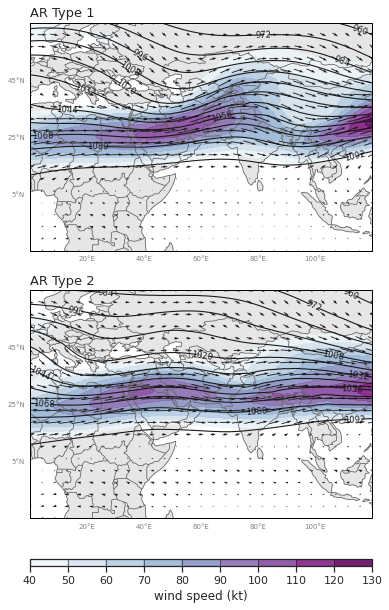

In [38]:
 # Create figure
fig = plt.figure(figsize=(15,10))
nrows = 2
ncols = 1

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.55,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.02, cbar_size='3%',label_mode='')

# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
    # Wind Speed (contour filled)
    clevs_wspd = np.arange(40,131,10)
    cf = ax.contourf(lons, lats, wspd_kt[k,:,:], transform=datacrs,
                     levels=clevs_wspd, cmap='BuPu', alpha=0.9)
    
    # Geopotenital height lines
    clevs_hgts = np.arange(840,1280,12)
    cs = ax.contour(lons, lats, hgts[k,:,:]/10., transform=datacrs,
                    levels=clevs_hgts, colors='k', linewidths=1.1)
    plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5)  
        
    # Wind barbs / vectors 
    ax.quiver(lons, lats, uwnd[k,:,:], vwnd[k,:,:], transform=datacrs, 
             color='k', regrid_shape=20, pivot='middle')
   # subtitles 
    ax.set_title(plt_labels[k], loc='left',fontsize=13)
    
    
# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True, extend='both')
cb.set_label('wind speed (kt)')

# Save figure
filepath = path_to_figs + 'ar_types_'+ fname_id + '.png'
plt.savefig(filepath, dpi=150, bbox_inches='tight')

# Show
plt.show()


In [39]:
# 250-hPa Heights
hgts = era_eof_comp.H.values/9.80665 # convert to geopotential height

# 250-hPa Winds (m/s)
uwnd = era_eof_comp.U.values * units('m/s')
vwnd = era_eof_comp.V.values * units('m/s')
wspd = mpcalc.wind_speed(uwnd, vwnd)

# 250-hPa Winds (knots)
uwnd_kt = wspd.to('kt')
vwnd_kt = wspd.to('kt')
wspd_kt = wspd.to('kt')
print(wspd_kt.min(), wspd_kt.max())

plt_labels = ['AR EOF1', 'AR EOF2']

0.0417787991464138 knot 120.64714050292969 knot


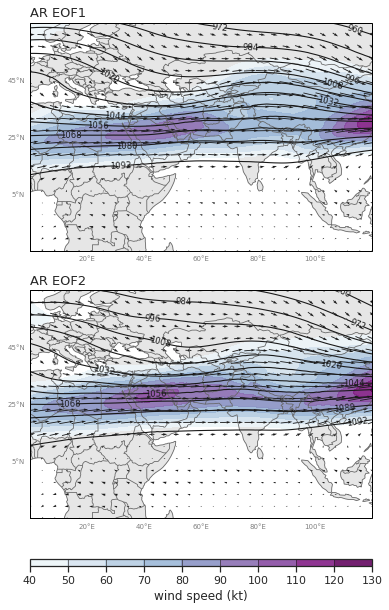

In [40]:
 # Create figure
fig = plt.figure(figsize=(15,10))
nrows = 2
ncols = 1

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.55,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.02, cbar_size='3%',label_mode='')

# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
    # Wind Speed (contour filled)
    clevs_wspd = np.arange(40,131,10)
    cf = ax.contourf(lons, lats, wspd_kt[k,:,:], transform=datacrs,
                     levels=clevs_wspd, cmap='BuPu', alpha=0.9)
    
    # Geopotenital height lines
    clevs_hgts = np.arange(840,1280,12)
    cs = ax.contour(lons, lats, hgts[k,:,:]/10., transform=datacrs,
                    levels=clevs_hgts, colors='k', linewidths=1.1)
    plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5)  
        
    # Wind barbs / vectors 
    ax.quiver(lons, lats, uwnd[k,:,:], vwnd[k,:,:], transform=datacrs, 
             color='k', regrid_shape=20, pivot='middle')
   # subtitles 
    ax.set_title(plt_labels[k], loc='left',fontsize=13)
    
    
# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True, extend='both')
cb.set_label('wind speed (kt)')

# Save figure
filepath = path_to_figs + 'eof_types_'+ fname_id + '.png'
plt.savefig(filepath, dpi=150, bbox_inches='tight')

# Show
plt.show()
